- https://www.kaggle.com/raddar/paris-madness/notebook

In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
import shap

# Load the data

In [2]:
# Environment Kaggle or Local?
ENVIRONMENT = 'local'

# Competition year 2019? or 2020?
COMPETITION_YEAR = 2019

In [3]:
if ENVIRONMENT == 'local' and COMPETITION_YEAR == 2019:
    tourney_detail = pd.read_csv('input/MDataFiles_Stage1/NCAATourneyDetailedResults.csv')
    tourney_detail_reload = pd.read_csv('input/MDataFiles_Stage1/NCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('input/MDataFiles_Stage1/NCAATourneySeeds.csv')
    regular_detail = pd.read_csv('input/MDataFiles_Stage1/Prelim2019_RegularSeasonDetailedResults.csv')
    regular_detail_reload = pd.read_csv('input/MDataFiles_Stage1/Prelim2019_RegularSeasonDetailedResults.csv')
    submission = pd.read_csv('input/SampleSubmissionStage2.csv')
    
elif ENVIRONMENT == 'local' and COMPETITION_YEAR == 2020:
    tourney_detail = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    tourney_detail_reload = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneySeeds.csv')
    regular_detail = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    regular_detail_reload = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    submission = pd.read_csv('input/MSampleSubmissionStage1_2020.csv')

elif ENVIRONMENT == 'kaggle' and COMPETITION_YEAR == 2019:
    tourney_detail = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneyDetailedResults.csv')
    tourney_detail_reload = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneySeeds.csv')
    regular_detail = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Prelim2019_RegularSeasonDetailedResults.csv')
    regular_detail_reload = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Prelim2019_RegularSeasonDetailedResults.csv')
    submission = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/SampleSubmissionStage2.csv')


In [4]:
tourney_detail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,2018,146,1242,85,1181,81,N,1,30,69,...,29,14,18,10,22,13,11,9,3,16
1044,2018,146,1437,71,1403,59,N,0,19,57,...,20,14,18,11,22,7,9,4,1,23
1045,2018,152,1276,69,1260,57,N,0,25,59,...,10,12,14,6,26,6,17,5,1,17
1046,2018,152,1437,95,1242,79,N,0,36,65,...,21,16,20,10,23,8,9,5,1,12


In [5]:
seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159


In [6]:
regular_detail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87361,2019,128,1412,70,1292,61,N,0,24,49,...,30,3,6,10,20,13,14,5,3,20
87362,2019,128,1417,79,1390,72,N,0,25,61,...,25,11,20,18,30,11,12,7,9,22
87363,2019,128,1425,78,1112,65,N,0,29,60,...,22,14,19,11,28,11,12,3,6,17
87364,2019,128,1439,71,1274,56,N,0,27,54,...,29,10,14,10,20,10,8,3,0,10


In [7]:
regular_detail.groupby('Season').mean().head()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,0.061308,26.299393,55.367851,6.695624,17.377166,...,18.720971,12.193674,18.055243,11.913345,21.115901,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,0.071319,25.928681,55.069350,6.708160,17.570335,...,18.825202,12.025159,18.057755,11.844235,21.224021,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,0.066524,25.975187,54.949305,6.769840,17.678503,...,18.922139,11.875722,17.767059,11.733690,21.038717,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,0.073996,25.920538,54.881228,6.845281,17.821526,...,18.882279,11.807862,17.589027,11.762035,20.874711,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,0.067618,25.896887,54.196907,7.043228,18.138608,...,19.453500,11.862978,17.645251,11.534404,20.671227,11.667460,15.218917,6.225858,2.760658,19.985524


In [8]:
tourney_detail.groupby('Season').mean().head()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,
2003,139.15625,1283.343750,76.562500,1288.765625,65.546875,0.093750,27.703125,57.906250,6.640625,16.281250,...,19.968750,12.281250,17.796875,12.421875,21.171875,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.15625,1286.515625,75.500000,1300.640625,64.265625,0.046875,25.890625,54.531250,6.906250,17.500000,...,20.468750,11.781250,16.750000,11.734375,20.593750,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.15625,1306.031250,75.562500,1299.562500,65.375000,0.109375,26.281250,54.609375,6.953125,18.015625,...,19.734375,11.984375,17.234375,12.359375,20.984375,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.15625,1282.250000,73.203125,1291.500000,63.171875,0.109375,24.984375,54.093750,6.609375,18.015625,...,19.890625,11.031250,15.625000,11.859375,21.375000,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.15625,1320.593750,75.703125,1299.421875,63.578125,0.093750,25.515625,54.250000,7.421875,18.406250,...,19.984375,11.656250,16.875000,11.359375,20.406250,11.500000,12.468750,5.906250,2.843750,20.328125


In [9]:
# Check if all columns are the same between regular_detail and tourney_detail
all(regular_detail.columns == tourney_detail.columns)

True

# Data Preparation

In [10]:
regular_detail.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [11]:
# Swap the features of winning team and losing team
regular_detail_swap = regular_detail[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [12]:
# Change winning location: "Home" to "Away", "Away" to "Home"
regular_detail_swap.loc[regular_detail['WLoc'] == 'H', 'WLoc'] = 'A'
regular_detail_swap.loc[regular_detail['WLoc'] == 'A', 'WLoc'] = 'H'

# Change "WLoc" to "location"
regular_detail.columns.values[6] = 'location'
regular_detail_swap.columns.values[6] = 'location'

In [13]:
# Change letter 'W' to 'T1_' and 'L' to 'T2_'
regular_detail.columns = [column.replace('W','T1_').replace('L','T2_') for column in regular_detail.columns]

# Change letter 'L' to 'T1_' and 'W' to 'T2_'
regular_detail_swap.columns = [column.replace('L','T1_').replace('W','T2_') for column in regular_detail.columns]

In [14]:
regular_detail.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [15]:
regular_detail_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1328,62,1104,68,N,0,22,53,...,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,...,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,...,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,...,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,...,14,11,13,17,22,12,14,4,4,20


In [16]:
# Concat regular_detail and regular_detail_swap together
regular_data = pd.concat([regular_detail, regular_detail_swap]).sort_index().reset_index(drop = True)

### Apply function to prepare data

In [17]:
def prepare_data(df):
    # Swap winnig team's columns and losing team's columns
    df_swap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    df_swap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    df_swap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    df_swap.columns.values[6] = 'location'    
      
    df.columns = [column.replace('W','T1_').replace('L','T2_') for column in df.columns]
    df_swap.columns = [column.replace('L','T1_').replace('W','T2_') for column in df_swap.columns]

    df_concat = pd.concat([df, df_swap]).reset_index(drop=True)
    
    # -1, 0, 1 encoding
    df_concat.loc[df_concat.location=='N','location'] = '0'
    df_concat.loc[df_concat.location=='H','location'] = '1'
    df_concat.loc[df_concat.location=='A','location'] = '-1'
    df_concat.location = df_concat.location.astype(int)
    
    df_concat['PointDiff'] = df_concat['T1_Score'] - df_concat['T2_Score']
    
    return df_concat

In [18]:
# Reload data ot put into the function
regular_data = prepare_data(regular_detail_reload)
tourney_data = prepare_data(tourney_detail_reload)

In [19]:
regular_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,...,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,...,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,...,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,...,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,...,17,27,21,15,12,10,7,1,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174727,2019,128,1292,61,1412,70,0,0,24,58,...,17,24,8,24,8,11,7,2,11,-9
174728,2019,128,1390,72,1417,79,0,0,27,76,...,22,35,12,37,9,15,7,1,20,-7
174729,2019,128,1112,65,1425,78,0,0,23,57,...,12,19,6,24,10,8,6,5,19,-13
174730,2019,128,1274,56,1439,71,0,0,19,56,...,6,7,8,28,17,10,4,3,15,-15


In [20]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,...,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,...,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,...,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,...,15,20,10,26,16,14,5,8,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,0,1,30,70,...,12,15,17,30,20,18,5,3,14,-4
2092,2018,146,1403,59,1437,71,0,0,20,60,...,29,35,20,31,7,12,6,4,17,-12
2093,2018,152,1260,57,1276,69,0,0,22,51,...,12,18,11,25,8,11,10,2,11,-12
2094,2018,152,1242,79,1437,95,0,0,28,62,...,5,7,7,26,20,10,3,5,14,-16


# Feature engineering

In [21]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [22]:
boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

funcs = [np.mean]

In [23]:
season_team_boxscore_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_team_boxscore_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,...,13.678571,19.250000,9.607143,20.142857,9.142857,12.964286,5.428571,1.571429,18.357143,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,...,15.925926,22.148148,12.037037,22.037037,15.481481,15.333333,6.407407,2.851852,22.444444,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,...,12.142857,17.142857,10.892857,22.642857,11.678571,13.857143,5.535714,3.178571,19.250000,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,...,16.384615,24.500000,13.192308,26.384615,15.807692,18.807692,9.384615,4.192308,19.076923,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,...,15.535714,21.964286,11.321429,22.357143,11.785714,15.071429,8.785714,3.178571,16.142857,-0.142857


In [24]:
season_team_boxscore_statistics.columns = [''.join(col).strip() for col in season_team_boxscore_statistics.columns.values]
season_team_boxscore_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,...,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,...,13.678571,19.250000,9.607143,20.142857,9.142857,12.964286,5.428571,1.571429,18.357143,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,...,15.925926,22.148148,12.037037,22.037037,15.481481,15.333333,6.407407,2.851852,22.444444,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,...,12.142857,17.142857,10.892857,22.642857,11.678571,13.857143,5.535714,3.178571,19.250000,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,...,16.384615,24.500000,13.192308,26.384615,15.807692,18.807692,9.384615,4.192308,19.076923,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,...,15.535714,21.964286,11.321429,22.357143,11.785714,15.071429,8.785714,3.178571,16.142857,-0.142857


In [25]:
season_T1_boxscore_stat = season_team_boxscore_statistics.copy()
season_T2_boxscore_stat = season_team_boxscore_statistics.copy()

season_T1_boxscore_stat.columns = ["T1_" + column.replace("T1_","").replace("T2_","opponent_") for column in season_T1_boxscore_stat.columns]
season_T2_boxscore_stat.columns = ["T2_" + column.replace("T1_","").replace("T2_","opponent_") for column in season_T2_boxscore_stat.columns]
season_T1_boxscore_stat.columns.values[0] = "Season"
season_T2_boxscore_stat.columns.values[0] = "Season"

In [26]:
season_T1_boxscore_stat.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,...,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,...,13.678571,19.250000,9.607143,20.142857,9.142857,12.964286,5.428571,1.571429,18.357143,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,...,15.925926,22.148148,12.037037,22.037037,15.481481,15.333333,6.407407,2.851852,22.444444,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,...,12.142857,17.142857,10.892857,22.642857,11.678571,13.857143,5.535714,3.178571,19.250000,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,...,16.384615,24.500000,13.192308,26.384615,15.807692,18.807692,9.384615,4.192308,19.076923,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,...,15.535714,21.964286,11.321429,22.357143,11.785714,15.071429,8.785714,3.178571,16.142857,-0.142857


In [27]:
season_T2_boxscore_stat.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,...,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,...,13.678571,19.250000,9.607143,20.142857,9.142857,12.964286,5.428571,1.571429,18.357143,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,...,15.925926,22.148148,12.037037,22.037037,15.481481,15.333333,6.407407,2.851852,22.444444,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,...,12.142857,17.142857,10.892857,22.642857,11.678571,13.857143,5.535714,3.178571,19.250000,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,...,16.384615,24.500000,13.192308,26.384615,15.807692,18.807692,9.384615,4.192308,19.076923,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,...,15.535714,21.964286,11.321429,22.357143,11.785714,15.071429,8.785714,3.178571,16.142857,-0.142857


In [28]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

In [29]:
tourney_data = pd.merge(tourney_data, season_T1_boxscore_stat, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_T2_boxscore_stat, on = ['Season', 'T2_TeamID'], how = 'left')

In [30]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,11.696970,16.696970,11.060606,21.363636,12.363636,17.060606,6.333333,2.575758,19.393939,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,15.400000,21.200000,10.533333,21.433333,12.566667,14.633333,7.433333,2.833333,19.333333,4.400000


In [31]:
# Extract the last 14days statistics (132 - 14 = 118)
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
# Winning rate of each team according to the season
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [32]:
last14days_stats_T1

,Season,T1_TeamID,T1_win_ratio_14d
0,2003,1102,0.333333
1,2003,1103,0.333333
2,2003,1104,0.333333
3,2003,1105,0.000000
4,2003,1106,0.500000
...,...,...,...
5611,2019,1462,0.500000
5612,2019,1463,0.500000
5613,2019,1464,0.000000
5614,2019,1465,0.500000


In [33]:
last14days_stats_T2

,Season,T2_TeamID,T2_win_ratio_14d
0,2003,1102,0.333333
1,2003,1103,0.333333
2,2003,1104,0.333333
3,2003,1105,0.000000
4,2003,1106,0.500000
...,...,...,...
5611,2019,1462,0.500000
5612,2019,1463,0.500000
5613,2019,1464,0.000000
5614,2019,1465,0.500000


In [34]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [35]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,11.060606,21.363636,12.363636,17.060606,6.333333,2.575758,19.393939,14.909091,1.000000,1.000000
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,10.533333,21.433333,12.566667,14.633333,7.433333,2.833333,19.333333,4.400000,0.333333,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,11.911765,23.235294,12.676471,13.000000,5.617647,3.558824,16.882353,10.558824,0.500000,0.800000
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,9.558824,23.147059,14.000000,13.117647,4.558824,2.676471,17.235294,16.176471,0.500000,1.000000
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,7.970588,24.647059,10.470588,12.852941,4.088235,3.235294,17.705882,10.117647,1.000000,1.000000
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,9.558824,23.147059,14.000000,13.117647,4.558824,2.676471,17.235294,16.176471,0.800000,1.000000


In [36]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)

In [37]:
regular_season_effects

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1266,1437,12,1
3,2003,1296,1457,6,1
4,2003,1400,1208,6,1
...,...,...,...,...,...
174727,2019,1292,1412,-9,0
174728,2019,1390,1417,-7,0
174729,2019,1112,1425,-13,0
174730,2019,1274,1439,-15,0


In [38]:
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness

,Season,TeamID_x,TeamID_y
0,1985,1207,1207
1,1985,1207,1210
2,1985,1207,1228
3,1985,1207,1260
4,1985,1207,1374
...,...,...,...
149397,2019,1205,1332
149398,2019,1205,1414
149399,2019,1205,1330
149400,2019,1205,1159


In [39]:
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)

# Extract tourney result from all result (including regular season)
# Default how='inner'
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1
...,...,...,...,...,...
9857,2019,1439,1199,-9,0
9858,2019,1279,1246,-4,0
9859,2019,1280,1397,-17,0
9860,2019,1397,1120,-4,0


In [42]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,11.060606,21.363636,12.363636,17.060606,6.333333,2.575758,19.393939,14.909091,1.000000,1.000000
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,10.533333,21.433333,12.566667,14.633333,7.433333,2.833333,19.333333,4.400000,0.333333,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,11.911765,23.235294,12.676471,13.000000,5.617647,3.558824,16.882353,10.558824,0.500000,0.800000
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,9.558824,23.147059,14.000000,13.117647,4.558824,2.676471,17.235294,16.176471,0.500000,1.000000
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,7.970588,24.647059,10.470588,12.852941,4.088235,3.235294,17.705882,10.117647,1.000000,1.000000
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,9.558824,23.147059,14.000000,13.117647,4.558824,2.676471,17.235294,16.176471,0.800000,1.000000


In [43]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [44]:
seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374


In [45]:
seeds_T1 = seeds[['Season','TeamID','Seed']].copy()
seeds_T2 = seeds[['Season','TeamID','Seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [46]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [47]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,17.060606,6.333333,2.575758,19.393939,14.909091,1.000000,1.000000,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,14.633333,7.433333,2.833333,19.333333,4.400000,0.333333,0.600000,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,13.000000,5.617647,3.558824,16.882353,10.558824,0.500000,0.800000,2,1,1
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,13.117647,4.558824,2.676471,17.235294,16.176471,0.500000,1.000000,3,1,2
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,12.852941,4.088235,3.235294,17.705882,10.117647,1.000000,1.000000,11,3,8
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,13.117647,4.558824,2.676471,17.235294,16.176471,0.800000,1.000000,1,1,0


# Modeling

In [48]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2096.00000
mean        0.00000
std        14.28837
min       -56.00000
25%       -10.00000
50%         0.00000
75%        10.00000
max        56.00000
dtype: float64

In [49]:
season_T1_boxscore_stat

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,...,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,...,13.678571,19.250000,9.607143,20.142857,9.142857,12.964286,5.428571,1.571429,18.357143,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,...,15.925926,22.148148,12.037037,22.037037,15.481481,15.333333,6.407407,2.851852,22.444444,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,...,12.142857,17.142857,10.892857,22.642857,11.678571,13.857143,5.535714,3.178571,19.250000,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,...,16.384615,24.500000,13.192308,26.384615,15.807692,18.807692,9.384615,4.192308,19.076923,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,...,15.535714,21.964286,11.321429,22.357143,11.785714,15.071429,8.785714,3.178571,16.142857,-0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,2019,1462,26.096774,55.516129,7.161290,21.032258,12.967742,18.806452,10.354839,25.741935,...,10.451613,14.774194,9.870968,22.000000,14.419355,11.096774,7.161290,3.161290,17.709677,1.419355
5830,2019,1463,29.692308,60.346154,8.000000,21.384615,12.807692,18.000000,8.884615,30.230769,...,14.000000,19.076923,9.538462,24.730769,13.038462,11.346154,7.461538,3.076923,16.961538,7.038462
5831,2019,1464,26.833333,63.633333,9.566667,28.000000,10.266667,14.733333,12.966667,24.000000,...,16.566667,22.533333,9.800000,25.766667,14.133333,11.500000,5.900000,3.333333,15.166667,-5.733333
5832,2019,1465,26.038462,59.038462,8.807692,25.230769,14.576923,18.961538,10.076923,26.269231,...,17.076923,24.038462,10.769231,24.961538,11.230769,10.807692,5.538462,2.615385,18.346154,0.269231


In [50]:
season_T1_boxscore_stat.columns

Index(['Season', 'T1_TeamID', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean',
       'T1_FGA3mean', 'T1_FTMmean', 'T1_FTAmean', 'T1_ORmean', 'T1_DRmean',
       'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_Blkmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_FTMmean', 'T1_opponent_FTAmean',
       'T1_opponent_ORmean', 'T1_opponent_DRmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'T1_opponent_PFmean', 'T1_PointDiffmean'],
      dtype='object')

In [51]:
seeds_T1.columns

Index(['Season', 'T1_TeamID', 'T1_seed'], dtype='object')

In [52]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,17.060606,6.333333,2.575758,19.393939,14.909091,1.000000,1.000000,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,14.633333,7.433333,2.833333,19.333333,4.400000,0.333333,0.600000,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,13.000000,5.617647,3.558824,16.882353,10.558824,0.500000,0.800000,2,1,1
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,13.117647,4.558824,2.676471,17.235294,16.176471,0.500000,1.000000,3,1,2
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,12.852941,4.088235,3.235294,17.705882,10.117647,1.000000,1.000000,11,3,8
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,13.117647,4.558824,2.676471,17.235294,16.176471,0.800000,1.000000,1,1,0


In [53]:
# Add Score Sum Feature
season_team_score_sum = regular_data.groupby(['Season', 'T1_TeamID'])['T1_Score'].sum().reset_index()
season_team_score_sum.rename(columns={'T1_TeamID': 'TeamID', 'T1_Score': 'Score_Sum'}, inplace=True)
season_team_score_sum

,Season,TeamID,Score_Sum
0,2003,1102,1603
1,2003,1103,2127
2,2003,1104,1940
3,2003,1105,1866
4,2003,1106,1781
...,...,...,...
5829,2019,1462,2242
5830,2019,1463,2085
5831,2019,1464,2205
5832,2019,1465,1962


In [54]:
tourney_data = pd.merge(tourney_data, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T1_TeamID'],
                        right_on=['Season', 'TeamID'])
tourney_data.rename(columns={'Score_Sum': 'T1_Score_Sum'}, inplace=True)
tourney_data.drop(['TeamID'], axis=1, inplace=True)
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,16,16,0,2065
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,1,16,-15,2386
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,10,7,3,2203
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,6.333333,2.575758,19.393939,14.909091,1.000000,1.000000,11,6,5,2301
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,7.433333,2.833333,19.333333,4.400000,0.333333,0.600000,8,9,-1,2160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,5.617647,3.558824,16.882353,10.558824,0.500000,0.800000,2,1,1,2795
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,4.558824,2.676471,17.235294,16.176471,0.500000,1.000000,3,1,2,2483
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,4.088235,3.235294,17.705882,10.117647,1.000000,1.000000,11,3,8,2294
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,4.558824,2.676471,17.235294,16.176471,0.800000,1.000000,1,1,0,2771


In [55]:
tourney_data = pd.merge(tourney_data, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T2_TeamID'],
                        right_on=['Season', 'TeamID'])
tourney_data.rename(columns={'Score_Sum': 'T2_Score_Sum'}, inplace=True)
tourney_data.drop(['TeamID'], axis=1, inplace=True)
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,2.600000,21.633333,1.966667,1.000000,0.833333,16,16,0,2065,2184
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,3.655172,17.931034,4.655172,0.666667,1.000000,1,16,-15,2386,1966
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,3.172414,19.931034,8.689655,0.666667,0.750000,10,7,3,2203,2161
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,2.575758,19.393939,14.909091,1.000000,1.000000,11,6,5,2301,2615
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,2.833333,19.333333,4.400000,0.333333,0.600000,8,9,-1,2160,2172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,3.558824,16.882353,10.558824,0.500000,0.800000,2,1,1,2795,2771
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,2.676471,17.235294,16.176471,0.500000,1.000000,3,1,2,2483,2960
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,3.235294,17.705882,10.117647,1.000000,1.000000,11,3,8,2294,2504
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,2.676471,17.235294,16.176471,0.800000,1.000000,1,1,0,2771,2960


In [56]:
# The most important 9 features
features = ['T1_seed', 'T2_seed', 'Seed_diff', 'T2_PointDiffmean',
            'T1_PointDiffmean', 'T1_Score_Sum', 'T2_Score_Sum',
            'T1_opponent_FGAmean', 'T2_opponent_FGAmean']

X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [57]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [58]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [59]:
xgb_cv = []
repeat_cv = 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.2081+0.120679	test-mae:11.2144+0.496705
[50]	train-mae:8.55399+0.0610248	test-mae:8.82198+0.308798
[100]	train-mae:8.31573+0.0681423	test-mae:8.76756+0.286112
Fold repeater 1
[0]	train-mae:11.2085+0.0463654	test-mae:11.217+0.177961
[50]	train-mae:8.54667+0.0460689	test-mae:8.85267+0.207258
Fold repeater 2
[0]	train-mae:11.2118+0.0603367	test-mae:11.2192+0.241228
[50]	train-mae:8.55426+0.0587819	test-mae:8.8431+0.232894
Fold repeater 3
[0]	train-mae:11.2105+0.106903	test-mae:11.2154+0.431796
[50]	train-mae:8.55612+0.100683	test-mae:8.80408+0.401394
[100]	train-mae:8.30957+0.110725	test-mae:8.76466+0.418514
Fold repeater 4
[0]	train-mae:11.2125+0.0606737	test-mae:11.2179+0.247087
[50]	train-mae:8.54827+0.0906049	test-mae:8.81208+0.341712
[100]	train-mae:8.30357+0.0815467	test-mae:8.76377+0.307136
Fold repeater 5
[0]	train-mae:11.2097+0.0755665	test-mae:11.2171+0.316479
[50]	train-mae:8.54987+0.0166176	test-mae:8.83002+0.0767422
[100]	train-mae:8.3019+0.02

In [60]:
xgb_cv

[    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
 0        11.208110       0.120679      11.214358      0.496705
 1        11.022554       0.120551      11.034428      0.492354
 2        10.851149       0.115881      10.869515      0.495793
 3        10.690297       0.111481      10.713436      0.496110
 4        10.540684       0.106229      10.571694      0.496558
 ..             ...            ...            ...           ...
 79        8.390262       0.065439       8.765238      0.287354
 80        8.386336       0.065626       8.764608      0.286470
 81        8.381690       0.065644       8.762858      0.285277
 82        8.377778       0.065655       8.760537      0.285581
 83        8.373343       0.065514       8.759277      0.285676
 
 [84 rows x 4 columns],
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
 0        11.208516       0.046365      11.217007      0.177961
 1        11.023520       0.047138      11.036818      0.189396
 2        10.851927       0.048951      10.870667      0.197739
 3        10.690733       0.050406      10.716425      0.210348
 4        10.538158       0.052897      10.572255      0.215937
 ..             ...            ...            ...           ...
 69        8.422405       0.043882       8.818700      0.187955
 70        8.417629       0.043934       8.817616      0.186488
 71        8.413000       0.043881       8.816265      0.186504
 72        8.408940       0.043891       8.816047      0.185527
 73        8.404815       0.043748       8.815833      0.185027
 
 [74 rows x 4 columns],
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
 0        11.211829       0.060337      11.219158      0.241228
 1        11.027565       0.054648      11.042610      0.230541
 2        10.857781       0.051426      10.878968      0.221109
 3        10.698129       0.050102      10.725163      0.212255
 4        10.546465       0.052130      10.581025      0.204637
 ..             ...            ...            ...           ...
 70        8.424097       0.056558       8.798803      0.242810
 71        8.419484       0.056599       8.798931      0.243099
 72        8.414862       0.056430       8.799224      0.243513
 73        8.409932       0.056310       8.798151      0.243780
 74        8.405132       0.056242       8.798108      0.243763
 
 [75 rows x 4 columns],
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
 0        11.210461       0.106903      11.215392      0.431796
 1        11.030269       0.103162      11.041566      0.416643
 2        10.856683       0.098619      10.875304      0.406275
 3        10.697111       0.092896      10.722641      0.399455
 4        10.545833       0.088955      10.575685      0.390868
 ..             ...            ...            ...           ...
 80        8.382127       0.109379       8.757485      0.418791
 81        8.378136       0.109231       8.756794      0.419261
 82        8.374444       0.108931       8.756644      0.419661
 83        8.370492       0.109101       8.756487      0.418748
 84        8.366254       0.109512       8.755894      0.418557
 
 [85 rows x 4 columns],
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
 0        11.212453       0.060674      11.217941      0.247087
 1        11.028815       0.062140      11.041273      0.258049
 2        10.854995       0.065890      10.874081      0.268031
 3        10.692203       0.068280      10.715670      0.276456
 4        10.541132       0.071601      10.570259      0.287462
 ..             ...            ...            ...           ...
 80        8.377018       0.084951       8.756724      0.317680
 81        8.372452       0.085076       8.756530      0.316532
 82        8.368429       0.084468       8.756634      0.316458
 83        8.364619       0.084003       8.755631      0.314524
 84        8.360921       0.083843       8.755185      0.313950
 
 [85 rows x 4 columns],
     train-mae-mean  train-mae

In [61]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([83, 73, 74, 84, 84, 77, 95, 84, 85, 85],
 [8.759277200000001,
  8.815833000000001,
  8.7981078,
  8.7558942,
  8.755184799999999,
  8.7832848,
  8.771434000000001,
  8.7755308,
  8.788,
  8.759407])

In [62]:
oof_preds = []
total_shap_df  = pd.DataFrame()

for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    
    feat_importance_df  = pd.DataFrame()
    
    for i, (train_index, val_index) in enumerate(kfold.split(X,y)):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        
        # Get shap values from xgb model
        shap_values = shap.TreeExplainer(model).shap_values(X[train_index])

        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = tourney_data[features].columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(0))
        # fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        # fold_importance_df['feat_imp'] = model.feature_importance
        if i == 0:
            feat_importance_df = fold_importance_df
        else:
            feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])

        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))
    
    feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
    total_shap_df = pd.concat([total_shap_df, feat_importance_df_shap])

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [63]:
shap_sorted_df = total_shap_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
shap_sorted_df

,feature,shap_values
0,T1_seed,0.041127
1,T2_seed,0.036839
2,Seed_diff,0.016139
3,T2_PointDiffmean,0.011863
4,T1_Score_Sum,0.010163
5,T1_opponent_FGAmean,0.009552
6,T1_PointDiffmean,0.009422
7,T2_Score_Sum,0.009346
8,T2_opponent_FGAmean,0.009284


In [64]:
shap_sorted_df[:40].feature.values

array(['T1_seed', 'T2_seed', 'Seed_diff', 'T2_PointDiffmean',
       'T1_Score_Sum', 'T1_opponent_FGAmean', 'T1_PointDiffmean',
       'T2_Score_Sum', 'T2_opponent_FGAmean'], dtype=object)

In [65]:
y

0        8
1       29
2       13
3        6
4        2
        ..
2091    -4
2092   -12
2093   -12
2094   -16
2095   -17
Length: 2096, dtype: int64

In [66]:
oof_preds

[0       -0.246935
 1       18.204342
 2       -1.836759
 3       -9.960290
 4       -1.900507
           ...    
 2091     0.700526
 2092    -3.166279
 2093    -5.479928
 2094    -1.668639
 2095    -4.637980
 Length: 2096, dtype: float64, 0        0.299494
 1       17.804022
 2       -0.769809
 3       -8.906889
 4       -1.657694
           ...    
 2091     0.471412
 2092    -4.514223
 2093    -4.706031
 2094    -2.123772
 2095    -4.235529
 Length: 2096, dtype: float64, 0       -0.493038
 1       18.372829
 2       -2.048913
 3      -10.989044
 4       -2.077945
           ...    
 2091     2.546487
 2092    -3.969171
 2093    -5.478222
 2094    -0.576825
 2095    -2.990436
 Length: 2096, dtype: float64, 0       -1.364515
 1       18.977486
 2       -0.601630
 3       -8.630662
 4       -1.867823
           ...    
 2091     0.055562
 2092    -3.364771
 2093    -5.726603
 2094    -3.953421
 2095    -3.115653
 Length: 2096, dtype: float64, 0       -2.847632
 1       18.671638
 2       -1.520162
 3       -9.118578
 4       -1.867002
           ...    
 2091     1.061313
 2092    -4.247190
 2093    -5.204047
 2094    -4.453072
 2095    -4.044011
 Length: 2096, dtype: float64, 0       -0.316094
 1       17.956337
 2       -2.576279
 3       -8.996968
 4       -1.746099
           ...    
 2091    -0.175963
 2092    -4.398005
 2093    -5.491168
 2094    -2.067827
 2095    -4.483445
 Length: 2096, dtype: float64, 0        1.317549
 1       18.657133
 2       -2.082845
 3       -9.805339
 4       -1.709126
           ...    
 2091     2.267232
 2092    -3.485047
 2093    -5.973346
 2094    -3.166160
 2095    -3.315766
 Length: 2096, dtype: float64, 0       -1.123416
 1       18.159260
 2       -2.213053
 3       -7.859744
 4       -1.434839
           ...    
 2091    -0.021497
 2092    -3.826185
 2093    -5.497705
 2094    -3.470882
 2095    -3.898946
 Length: 2096, dtype: float64, 0       -1.302667
 1       17.957941
 2       -1.951678
 3       -9.289642
 4       -2.569664
           ...    
 2091     0.189268
 2092    -4.028906
 2093    -4.952799
 2094    -3.571773
 2095    -4.892250
 Length: 2096, dtype: float64, 0       -2.666509
 1       18.468275
 2       -1.179128
 3      -10.077888
 4       -1.755553
           ...    
 2091     1.715336
 2092    -4.080712
 2093    -6.023129
 2094    -2.784192
 2095    -4.963418
 Length: 2096, dtype: float64]

In [67]:
oof_preds[0]

0       -0.246935
1       18.204342
2       -1.836759
3       -9.960290
4       -1.900507
          ...    
2091     0.700526
2092    -3.166279
2093    -5.479928
2094    -1.668639
2095    -4.637980
Length: 2096, dtype: float64

[<matplotlib.lines.Line2D at 0x1756134cb38>]

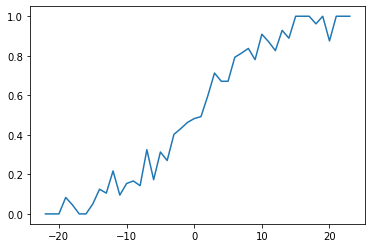

In [68]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [69]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5453665728996829
logloss of cvsplit 1: 0.5469474360612785
logloss of cvsplit 2: 0.5482146760213492
logloss of cvsplit 3: 0.5463052709706879
logloss of cvsplit 4: 0.545069858696909
logloss of cvsplit 5: 0.5477819786728305
logloss of cvsplit 6: 0.5453666607233907
logloss of cvsplit 7: 0.5457935457527462
logloss of cvsplit 8: 0.548238730592333
logloss of cvsplit 9: 0.5457200176237115


[<matplotlib.lines.Line2D at 0x17561df75c0>]

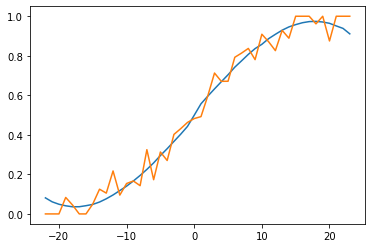

In [70]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [71]:
plot_df

,pred_int,spline,label
0,-22,0.081195,0.000000
1,-21,0.061122,0.000000
2,-20,0.048893,0.000000
3,-19,0.041099,0.083333
4,-18,0.036119,0.045455
5,-17,0.036325,0.000000
6,-16,0.041595,0.000000
7,-15,0.048125,0.050000
8,-14,0.060110,0.125000
9,-13,0.076583,0.105263


In [72]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5453665728996829
adjusted logloss of cvsplit 1: 0.5469474360612785
adjusted logloss of cvsplit 2: 0.5482146760213492
adjusted logloss of cvsplit 3: 0.5463052709706879
adjusted logloss of cvsplit 4: 0.545069858696909
adjusted logloss of cvsplit 5: 0.5477819786728305
adjusted logloss of cvsplit 6: 0.5453666607233907
adjusted logloss of cvsplit 7: 0.5457935457527462
adjusted logloss of cvsplit 8: 0.548238730592333
adjusted logloss of cvsplit 9: 0.5457200176237115


In [73]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5727353587468156
adjusted logloss of cvsplit 1: 0.5744770256196088
adjusted logloss of cvsplit 2: 0.5755693444732399
adjusted logloss of cvsplit 3: 0.5738103993226
adjusted logloss of cvsplit 4: 0.5725185212762692
adjusted logloss of cvsplit 5: 0.5753051328831728
adjusted logloss of cvsplit 6: 0.5727965639921315
adjusted logloss of cvsplit 7: 0.5731966862944868
adjusted logloss of cvsplit 8: 0.5755452225622609
adjusted logloss of cvsplit 9: 0.5730888326684291


In [74]:
spline_model

[<scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x175613a5d30>,
 <scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x1756133bef0>,
 <scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x17561309f98>,
 <scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x17561d53be0>,
 <scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x17561d53f28>,
 <scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x17561d53400>,
 <scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x17561d53f98>,
 <scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x17561e33080>,
 <scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x17561e33e48>,
 <scipy.interpolate.fitpack2.LSQUnivariateSpline at 0x1755d992828>]

In [75]:
spline_fit

array([0.39921508, 1.        , 0.45569354, ..., 0.27789583, 0.39479433,
       0.31492575])

In [76]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
).sort_values(['Season'])

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum
2062,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,...,2.806452,18.774194,1.516129,1.0,1.0,1,16,-15,2229,2247
1014,2018,137,1420,74,1438,54,25.612903,58.451613,9.838710,25.774194,...,2.636364,15.060606,14.151515,1.0,1.0,16,1,15,2247,2229


In [77]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5428779996156518
adjusted logloss of cvsplit 1: 0.5446273852612767
adjusted logloss of cvsplit 2: 0.5457254847998111
adjusted logloss of cvsplit 3: 0.5438585502403632
adjusted logloss of cvsplit 4: 0.5427438740215357
adjusted logloss of cvsplit 5: 0.5455472199691581
adjusted logloss of cvsplit 6: 0.5431430885564575
adjusted logloss of cvsplit 7: 0.543523768824235
adjusted logloss of cvsplit 8: 0.5457488914141623
adjusted logloss of cvsplit 9: 0.5432889773511277


In [78]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.5402075270981034
adjusted logloss of cvsplit 1: 0.5417547619265984
adjusted logloss of cvsplit 2: 0.542828512915511
adjusted logloss of cvsplit 3: 0.5410401216717577
adjusted logloss of cvsplit 4: 0.5401386813707418
adjusted logloss of cvsplit 5: 0.5427757493404763
adjusted logloss of cvsplit 6: 0.5405450424269665
adjusted logloss of cvsplit 7: 0.5408267054247746
adjusted logloss of cvsplit 8: 0.542871315000059
adjusted logloss of cvsplit 9: 0.5405167254768312


season
2003    0.545427
2004    0.509072
2005    0.494519
2006    0.559809
2007    0.443620
2008    0.473737
2009    0.483679
2010    0.563046
2011    0.604454
2012    0.568940
2013    0.610864
2014    0.588827
2015    0.515813
2016    0.583336
2017    0.504612
2018    0.600306
dtype: float64

# Submission time!

In [79]:
submission

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5
...,...,...
2273,2019_1449_1459,0.5
2274,2019_1449_1463,0.5
2275,2019_1458_1459,0.5
2276,2019_1458_1463,0.5


In [80]:
submission["Season"] = submission["ID"].apply(lambda x: x[:4]).astype(int)
submission["T1_TeamID"] = submission["ID"].apply(lambda x: x[5:9]).astype(int)
submission["T2_TeamID"] = submission["ID"].apply(lambda x: x[10:14]).astype(int)
submission

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2019_1101_1113,0.5,2019,1101,1113
1,2019_1101_1120,0.5,2019,1101,1120
2,2019_1101_1124,0.5,2019,1101,1124
3,2019_1101_1125,0.5,2019,1101,1125
4,2019_1101_1133,0.5,2019,1101,1133
...,...,...,...,...,...
2273,2019_1449_1459,0.5,2019,1449,1459
2274,2019_1449_1463,0.5,2019,1449,1463
2275,2019_1458_1459,0.5,2019,1458,1459
2276,2019_1458_1463,0.5,2019,1458,1463


In [81]:
submission = pd.merge(submission, season_T1_boxscore_stat, on = ['Season', 'T1_TeamID'])
submission = pd.merge(submission, season_T2_boxscore_stat, on = ['Season', 'T2_TeamID'])
submission = pd.merge(submission, seeds_T1, on = ['Season', 'T1_TeamID'])
submission = pd.merge(submission, seeds_T2, on = ['Season', 'T2_TeamID'])
submission = pd.merge(submission, last14days_stats_T1, on = ['Season', 'T1_TeamID'])
submission = pd.merge(submission, last14days_stats_T2, on = ['Season', 'T2_TeamID'])
submission["Seed_diff"] = submission["T1_seed"] - submission["T2_seed"]

In [82]:
# Add Score Sum Feature
season_team_score_sum = regular_data.groupby(['Season', 'T1_TeamID'])['T1_Score'].sum().reset_index()
season_team_score_sum.rename(columns={'T1_TeamID': 'TeamID', 'T1_Score': 'Score_Sum'}, inplace=True)
season_team_score_sum

submission = pd.merge(submission, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T1_TeamID'],
                        right_on=['Season', 'TeamID'])
submission.rename(columns={'Score_Sum': 'T1_Score_Sum'}, inplace=True)
submission.drop(['TeamID'], axis=1, inplace=True)

submission = pd.merge(submission, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T2_TeamID'],
                        right_on=['Season', 'TeamID'])
submission.rename(columns={'Score_Sum': 'T2_Score_Sum'}, inplace=True)
submission.drop(['TeamID'], axis=1, inplace=True)

In [83]:
submission

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,...,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff,T1_Score_Sum,T2_Score_Sum
0,2019_1101_1113,0.5,2019,1101,1113,25.296296,55.333333,7.370370,19.111111,13.666667,...,3.233333,21.600000,4.833333,15,11,1.000000,1.0,4,1934,2332
1,2019_1101_1120,0.5,2019,1101,1120,25.296296,55.333333,7.370370,19.111111,13.666667,...,3.733333,17.500000,10.266667,15,5,1.000000,1.0,10,1934,2379
2,2019_1113_1120,0.5,2019,1113,1120,26.633333,59.566667,7.266667,21.533333,17.200000,...,3.733333,17.500000,10.266667,11,5,1.000000,1.0,6,2332,2379
3,2019_1101_1124,0.5,2019,1101,1124,25.296296,55.333333,7.370370,19.111111,13.666667,...,4.193548,18.161290,5.161290,15,9,1.000000,0.0,6,1934,2227
4,2019_1113_1124,0.5,2019,1113,1124,26.633333,59.566667,7.266667,21.533333,17.200000,...,4.193548,18.161290,5.161290,11,9,1.000000,0.0,2,2332,2227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2019_1438_1463,0.5,2019,1438,1463,25.766667,53.800000,8.533333,20.600000,12.066667,...,3.076923,16.961538,7.038462,1,14,1.000000,0.5,-13,2164,2085
2274,2019_1439_1463,0.5,2019,1439,1463,25.741935,54.000000,9.774194,24.516129,13.096774,...,3.076923,16.961538,7.038462,4,14,0.666667,0.5,-10,2305,2085
2275,2019_1449_1463,0.5,2019,1449,1463,24.741935,54.129032,7.387097,21.258065,13.516129,...,3.076923,16.961538,7.038462,9,14,0.500000,0.5,-5,2182,2085
2276,2019_1458_1463,0.5,2019,1458,1463,26.000000,57.000000,7.290323,19.483871,10.322581,...,3.076923,16.961538,7.038462,5,14,1.000000,0.5,-9,2158,2085


In [84]:
X_submission = submission[features].values
dtest = xgb.DMatrix(X_submission)

In [85]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [86]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
submission["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

submission.loc[(submission.T1_seed==1) & (submission.T2_seed==16), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==2) & (submission.T2_seed==15), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==3) & (submission.T2_seed==14), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==16) & (submission.T2_seed==1), 'Pred'] = 0.0
submission.loc[(submission.T1_seed==15) & (submission.T2_seed==2), 'Pred'] = 0.0
submission.loc[(submission.T1_seed==14) & (submission.T2_seed==3), 'Pred'] = 0.0

if COMPETITION_YEAR == 2019:
    submission[['ID','Pred']].to_csv("submission-Men-2019.csv", index = None)
elif COMPETITION_YEAR == 2020:
    submission[['ID','Pred']].to_csv("submission-Men-2020.csv", index = None)

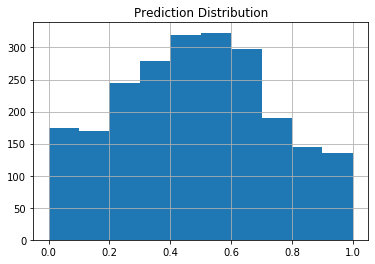

In [87]:
submission['Pred'].hist()
plt.title('Prediction Distribution');